In [4]:
import itertools
import random
import time

import numpy as np
import torch
import torchvision.datasets
from torch import nn

from utils import InMemDataLoader, Model, Model2D, Dropout, compute_error_rate, BatchNorm2d, plot_history, clear_output, SGD

In [5]:
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

In [6]:
batch_size = 128
data_path = "../data"

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.1307,), (0.3081,))]
)

_test = torchvision.datasets.MNIST(data_path, train=False, download=True, transform=transform)

# Load training data, split into train and valid sets
_train = torchvision.datasets.MNIST(data_path, train=True, download=True, transform=transform)
_train.data = _train.data[:50000]
_train.targets = _train.targets[:50000]

_valid = torchvision.datasets.MNIST(data_path, train=True, download=True, transform=transform)
_valid.data = _valid.data[50000:]
_valid.targets = _valid.targets[50000:]

mnist_loaders = {
    "train": InMemDataLoader(_train, batch_size=batch_size, shuffle=True),
    "valid": InMemDataLoader(_valid, batch_size=batch_size, shuffle=False),
    "test": InMemDataLoader(_test, batch_size=batch_size, shuffle=False),
}

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

-----------------------------------------------------------
After epoch 100 | valid err rate:  0.99% | doing 146 epochs
-----------------------------------------------------------

Loading best params on validation set (epoch 97)

--------------------------------------------
Test error rate: 0.860%, training took 974s.
--------------------------------------------


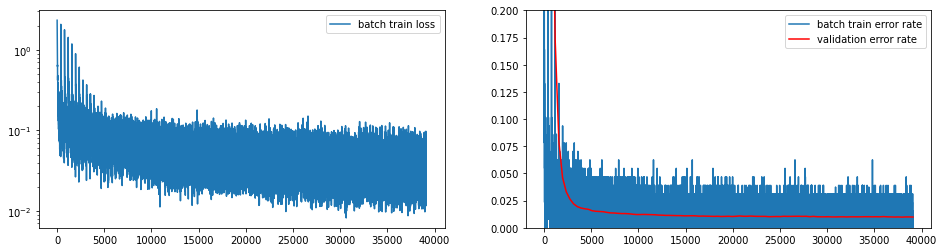

In [15]:
model = Model2D(
    Dropout(0.2),
    nn.Conv2d(1, 64, (3, 3)), nn.ReLU(inplace=True), nn.MaxPool2d((2, 2)), BatchNorm2d(64),
    nn.Conv2d(64, 128, (3, 3)), nn.ReLU(inplace=True), nn.MaxPool2d((2, 2)), BatchNorm2d(128),
    nn.Conv2d(128, 256, (3, 3)), nn.ReLU(inplace=True), nn.MaxPool2d((3, 3)), BatchNorm2d(256),
    Model(
        nn.Linear(256, 10),
    ),
)

with torch.no_grad():
    # Initialize parameters
    for name, p in model.named_parameters():
        if "weight" in name:
            nn.init.xavier_normal_(p, gain=nn.init.calculate_gain("relu"))
        elif "bias" in name:
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % name)

def alpha():
    yield from itertools.repeat(1e-1, 15)
    yield from itertools.repeat(5e-2, 15)
    yield from itertools.repeat(2e-2)

# On GPU enabled devices set device='cuda' else set device='cpu'
t_start = time.time()
SGD(model, mnist_loaders, alpha=alpha(), epsilon=1e-2, polyak_averaging=0.9, decay=1e-5, device="cuda", max_num_epochs=100)


test_err_rate = compute_error_rate(model, mnist_loaders["test"])
m = (
    f"Test error rate: {test_err_rate * 100.0:.3f}%, "
    f"training took {time.time() - t_start:.0f}s."
)
print("{0}\n{1}\n{0}".format("-" * len(m), m))